In [ ]:
import tensorflow_datasets as tfds
# reference: https://www.youtube.com/watch?v=c2kKFSkAF10

In [ ]:
(train_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised=True)

In [ ]:
len(train_dataset), len(test_dataset)

(18610, 4652)

In [ ]:
for X, y in train_dataset:
  print(X.shape, y.numpy())
  image_1 = X.numpy()
  break

(262, 350, 3) 1


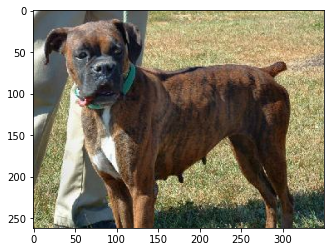

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_1)

In [ ]:
import tensorflow as tf

def normalize_img(image, label):
  return (tf.cast(image, tf.float32) / 255.0, label)

def resize(image, label):
  return (tf.image.resize(image, (224, 224)), label)

In [ ]:
train_dataset = train_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
SHUFFLE_VAL = len(train_dataset) // 1000   # Divide by big value on free Colab
BATCH_SIZE = 4   # Use small batch size on free Colab

train_dataset = train_dataset.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
for (img, label) in train_dataset:
  print(img.numpy().shape, label.numpy())
  break

(4, 224, 224, 3) [0 1 1 1]


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def AlexNet():
  inp = layers.Input((224, 224, 3))
  x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(3, 2)(x)
  x = layers.Conv2D(256, 5, 1, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(3, 2)(x)
  x = layers.Conv2D(384, 3, 1, activation='relu')(x)
  x = layers.Conv2D(384, 3, 1, activation='relu')(x)
  x = layers.Conv2D(256, 3, 1, activation='relu')(x)
  x = layers.MaxPooling2D(3, 2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inp, outputs=x)

  return model

model = AlexNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 256)      1024  

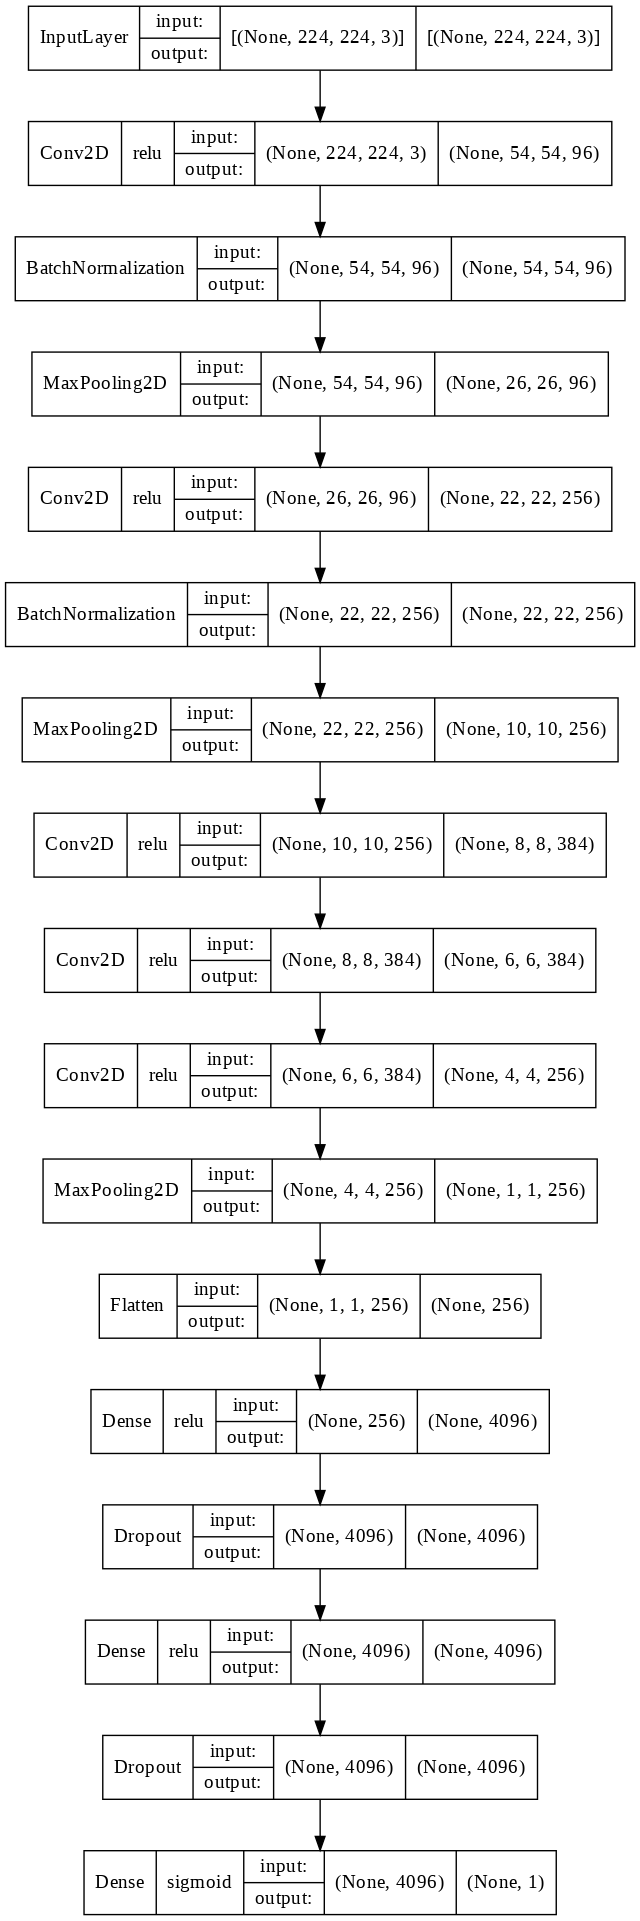

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
for (img, label) in train_dataset:
  print(model(img).numpy().shape, label.numpy())
  break

(4, 1) [0 0 1 1]


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, 
                   monitor='loss')

In [ ]:
model.fit(train_dataset, epochs=100, validation_data=test_dataset,
          callbacks=[es])

Epoch 1/100
 136/4653 [..............................] - ETA: 21:45 - loss: 0.9034 - accuracy: 0.5312

KeyboardInterrupt: ignored